In [2]:
import math
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Utility

In [6]:

class BoltzmannMachine:
    def __init__(self, env_states, num_hnodes):
        self.rng = np.random.default_rng()
        self.env_states = env_states
        self.num_vnodes = env_states.shape[1]
        self.num_hnodes = num_hnodes
        
        self.num_nodes = self.num_vnodes + self.num_hnodes + 1 # last node is for conversion of bias to weights
        self.W = np.zeros((self.num_nodes, self.num_nodes))
        self.sa_sched = [(2, 20), (2, 15), (2, 12), (4, 10)] # list of tuple of `time` and `temperature`
        self.equil_time_temp = (10, 10)
        self.weight_update_magnitude = 2 # refer paper - pp. 12

        self.free_run_debug = []
        self.energy_change_debug = []

    def get_rand_init_state(self, env_state=None):
        if env_state is not None:
            vec = np.zeros(self.num_nodes)
            vec[:self.num_vnodes] = env_state

            rand_hstate = self.rng.integers(0, 2, size=self.num_hnodes)
            vec[self.num_vnodes:-1] = rand_hstate
        else:
            vec = self.rng.integers(0, 2, size=self.num_nodes)
        
        
        vec[-1] = 1
        
        return vec
    

    def sigmoid(self, x, T):
        return 1 / (1 + math.exp(-x/T))
    

    def one_time_run(self, init_state, idxs, T):
        one_time_states = []

        # self.rng.shuffle(idxs) # this is exactly not equal to the definition of time unit in the paper.
        # for i in idxs:
        for _ in range(len(idxs)): # this follows the definition of `time`
            i = self.rng.choice(idxs, 1).item()
            energy_change = np.dot(self.W[i][:], init_state)
            self.energy_change_debug.append(energy_change)
            p_of_1 = self.sigmoid(energy_change, T)
            
            if self.rng.uniform(0, 1)<p_of_1:
                init_state[i] = 1
            else:
                init_state[i] = 0

            one_time_states.append(init_state.copy())

        return one_time_states
    
    def run(self, init_state, idxs):
        equi_states = []

        # as mentioned in the paper, network was allowed to reach equilibrium twice (pp. 11).
        for i in range(2):
            #SA
            for times, T in self.sa_sched:
                for t in range(times):
                    self.one_time_run(init_state, idxs, T)

            # now it is assumed that it has reached equilibrium, now getting the stats at equilibrium.
            for t in range(self.equil_time_temp[0]):
                equi_states.extend(self.one_time_run(init_state, idxs, self.equil_time_temp[1]))

        return equi_states


    def free_run(self):
        init_state = self.get_rand_init_state()
        
        #*********
        idxs = np.arange(self.num_vnodes + self.num_hnodes)
        #*********
        
        equi_states = self.run(init_state, idxs)    
        equi_states = np.array(equi_states)
        p_prime = (equi_states.T@equi_states)/equi_states.shape[0]

        self.free_run_debug.append({
            'equi_states': equi_states,
            'energies': np.array([self.calc_energy(state_) for state_ in equi_states]),
            'W': self.W.copy()
        })

        return p_prime

    def clamped_run(self):
        equi_states = []
        for env_state in self.env_states:
            init_state = self.get_rand_init_state(env_state)
            
            #*********
            idxs = np.arange(self.num_vnodes, self.num_vnodes+self.num_hnodes)
            #*********
            
            clamped_equi_states = self.run(init_state, idxs)
            equi_states.extend(clamped_equi_states)

        equi_states = np.array(equi_states)
        p = (equi_states.T@equi_states)/equi_states.shape[0]
        return p
    
    def search(self, query):
        '''
        `-1` in the query represents the nodes which needs to be filled.
        '''
        mask = (query==-1)
        query[mask] = self.rng.uniform(0, 2, size=mask.sum())
        init_state = self.get_rand_init_state(query)
        
        idxs_free_vis = np.nonzero(mask)[0]
        idxs_hid = np.arange(self.num_vnodes, self.num_vnodes+self.num_hnodes)
        
        #*********
        idxs = np.append(idxs_free_vis, idxs_hid)
        #*********

        equi_states = self.run(init_state, idxs)
        equi_states = np.array(equi_states)
        return equi_states
        

    
    def learn(self, learning_cycles):
        W_progression = []
        for _ in tqdm(range(learning_cycles)):
            p_prime = self.free_run()
            p = self.clamped_run()
            
            #DIRECTION OF UPDATE - whether to inc or dec
            direction = np.sign(p-p_prime)
            np.fill_diagonal(direction, 0)
            
            #WEIGHT UPDATE by fixed magnitude
            self.W = self.W + direction*self.weight_update_magnitude
            W_progression.append(self.W.copy())
            
        return W_progression
    
    def calc_energy(self, state):
        energy = -(state@(self.W@state))*0.5
        return energy
    
def parity_problem_testing(env_states, bm):
    test_res = []
    for query in env_states:
        query = query.copy()
        ans = query[2]
        query[2] = -1
        print(query, end=', ')

        res = bm.search(query)
        uniqs, uniqs_counts = np.unique(res[:, 2], return_counts=True)
        pred = uniqs[np.argmax(uniqs_counts)]
        is_correct = (pred==ans)
        print(uniqs, uniqs_counts, is_correct)
        test_res.append(is_correct)

    print(f'Result: {sum(test_res)}/4')

def plot_sigmoid(max_x, T):
    x = np.arange(-max_x, max_x)
    y = 1 / (1 + np.exp(-x/T))
    plt.plot(x, y)


# Exp1: Parity Problem

In [4]:
env_states = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
    ])

all_states = np.array([[0, 0, 0, 0, 1],
                    [0, 0, 0, 1, 1],
                    [0, 0, 1, 0, 1],
                    [0, 0, 1, 1, 1],
                    [0, 1, 0, 0, 1],
                    [0, 1, 0, 1, 1],
                    [0, 1, 1, 0, 1],
                    [0, 1, 1, 1, 1],
                    [1, 0, 0, 0, 1],
                    [1, 0, 0, 1, 1],
                    [1, 0, 1, 0, 1],
                    [1, 0, 1, 1, 1],
                    [1, 1, 0, 0, 1],
                    [1, 1, 0, 1, 1],
                    [1, 1, 1, 0, 1],
                    [1, 1, 1, 1, 1]])

num_hid_nodes = 1
bm = BoltzmannMachine(env_states, num_hid_nodes)
bm.equil_time_temp = (10000, 3)
bm.weight_update_magnitude = 1

Ws = bm.learn(20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
with PdfPages('ws_plots.pdf') as pdf:
    for W_ in Ws:
        plt.hist(W_.flatten())
        pdf.savefig()
        plt.close()

with PdfPages('plots.pdf') as pdf:
    for debug_dict in bm.free_run_debug:
        # bm_test = BoltzmannMachine(env_states, 1)
        # bm_test.W = debug_dict['W']
        plt.hist(debug_dict['energies'])
        # plt.show()
        # plt.title('Line Plot')
        # plt.xlabel('X-axis')
        # plt.ylabel('Y-axis')
        # plt.legend()
        pdf.savefig()  # Save the current figure into the PDF
        plt.close()  # Close the figure


print('PDFs generated!')

PDFs generated!


In [12]:
# testing
for i, W_ in enumerate(Ws[-5:]):
    print(f'#{i}')
    bm_test = BoltzmannMachine(env_states, 1)
    bm_test.equil_time_temp = (10000, 3)
    bm_test.W = W_
    parity_problem_testing(env_states, bm_test)
    print('-'*40)

#0
[ 0  0 -1], [0. 1.] [19859 20141] False
[ 0  1 -1], [0. 1.] [26404 13596] False
[ 1  0 -1], [0. 1.] [20045 19955] False
[ 1  1 -1], [0. 1.] [26216 13784] True
Result: 1/4
----------------------------------------
#1
[ 0  0 -1], [0. 1.] [16235 23765] False
[ 0  1 -1], [0. 1.] [19452 20548] True
[ 1  0 -1], [0. 1.] [12833 27167] True
[ 1  1 -1], [0. 1.] [16415 23585] False
Result: 2/4
----------------------------------------
#2
[ 0  0 -1], [0. 1.] [19960 20040] False
[ 0  1 -1], [0. 1.] [26507 13493] False
[ 1  0 -1], [0. 1.] [19873 20127] True
[ 1  1 -1], [0. 1.] [26493 13507] True
Result: 2/4
----------------------------------------
#3
[ 0  0 -1], [0. 1.] [16541 23459] False
[ 0  1 -1], [0. 1.] [19664 20336] True
[ 1  0 -1], [0. 1.] [13151 26849] True
[ 1  1 -1], [0. 1.] [16281 23719] False
Result: 2/4
----------------------------------------
#4
[ 0  0 -1], [0. 1.] [19928 20072] False
[ 0  1 -1], [0. 1.] [26723 13277] False
[ 1  0 -1], [0. 1.] [19903 20097] True
[ 1  1 -1], [0. 1.] [

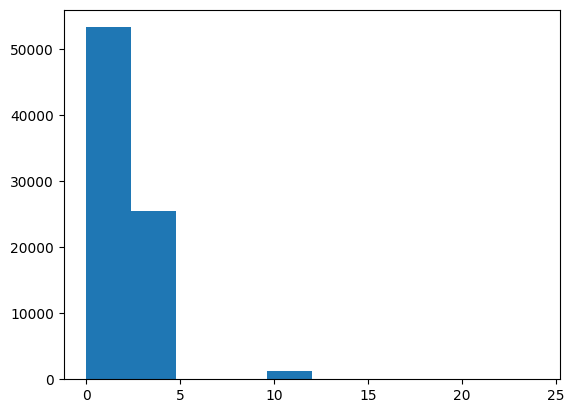

[0. 0. 0. 0. 1.] 12001 -0.0
[0. 0. 0. 1. 1.] 325 11.0
[0. 0. 1. 0. 1.] 6338 2.0
[0. 0. 1. 1. 1.] 8 24.0
[0. 1. 0. 0. 1.] 4319 3.0
[0. 1. 0. 1. 1.] 4565 3.0
[0. 1. 1. 0. 1.] 12120 -0.0
[0. 1. 1. 1. 1.] 277 11.0
[1. 0. 0. 0. 1.] 4273 3.0
[1. 0. 0. 1. 1.] 3998 3.0
[1. 0. 1. 0. 1.] 11779 -0.0
[1. 0. 1. 1. 1.] 303 11.0
[1. 1. 0. 0. 1.] 291 11.0
[1. 1. 0. 1. 1.] 11076 -0.0
[1. 1. 1. 0. 1.] 4373 3.0
[1. 1. 1. 1. 1.] 3954 3.0


In [ ]:
# GT

# gt_W = np.array([
#     [0, 0, 1, 1, 0],
#     [0, 0, 1, 1, 0],
#     [1, 1, 0, -2, -0.5],
#     [1, 1, -2, 0, -1.1],
#     [0, 0, -0.5, -1.1, 0]
# ])

# GT from paper
gt_W = np.array([
    [0, -5, 5, 11, -3],
    [-5, 0, 5, 11, -3],
    [5, 5, 0, -11, -2],
    [11, 11, -11, 0, -11],
    [-3, -3, -2, -11, 0]
])

gt_bm = BoltzmannMachine(env_states, 1)
gt_bm.W = gt_W
gt_bm.equil_time_temp = (10000, 3)

# parity_problem_testing(env_states, gt_bm)


#------ energy distribution
query = np.ones(3)*-1
equi_states = gt_bm.search(query)

energies = np.array([gt_bm.calc_energy(state) for state in equi_states])
# np.unique(energies, return_counts=True)
plt.hist(energies)
plt.show()

equi_dist = np.unique(equi_states, axis=0, return_counts=True)
states, state_counts = equi_dist

for state, count in zip(states, state_counts):
    print(state, count, gt_bm.calc_energy(state))


for _ in range(5):
    parity_problem_testing(env_states, gt_bm)

In [14]:
for _ in range(5):
    parity_problem_testing(env_states, gt_bm)

[ 0  0 -1], [0. 1.] [26664 13336] True
[ 0  1 -1], [0. 1.] [16492 23508] True
[ 1  0 -1], [0. 1.] [16593 23407] True
[ 1  1 -1], [0. 1.] [23998 16002] True
Result: 4/4
[ 0  0 -1], [0. 1.] [26695 13305] True
[ 0  1 -1], [0. 1.] [16612 23388] True
[ 1  0 -1], [0. 1.] [16885 23115] True
[ 1  1 -1], [0. 1.] [23181 16819] True
Result: 4/4
[ 0  0 -1], [0. 1.] [26811 13189] True
[ 0  1 -1], [0. 1.] [16976 23024] True
[ 1  0 -1], [0. 1.] [16611 23389] True
[ 1  1 -1], [0. 1.] [23580 16420] True
Result: 4/4
[ 0  0 -1], [0. 1.] [26795 13205] True
[ 0  1 -1], [0. 1.] [16782 23218] True
[ 1  0 -1], [0. 1.] [16466 23534] True
[ 1  1 -1], [0. 1.] [23437 16563] True
Result: 4/4
[ 0  0 -1], [0. 1.] [26550 13450] True
[ 0  1 -1], [0. 1.] [17191 22809] True
[ 1  0 -1], [0. 1.] [16353 23647] True
[ 1  1 -1], [0. 1.] [23106 16894] True
Result: 4/4
